# KL2d_figures_truncations

To accompany the paper *Generating Random Earthquake Events for Probabilistic Tsunami Hazard Assessment*, by R. J. LeVeque, K. Waagan, F. I. Gonzlez, D. Rim, and G. Lin, http://arxiv.org/abs/1605.02863. 

This code and related files can be found in https://github.com/rjleveque/KLslip-paper.  See the README.md file for information on dependencies.

This notebook has the code used to compute Figure 13 in the paper, showing the total variation distance between truncations of the K-L series, both for a 40% correlation length and then for a 20% correlation length.  This notebook takes much longer to execute than the others (several hours).

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys, os

from clawpack.geoclaw import topotools
from clawpack.visclaw import colormaps

import dtopotools

from scipy import stats
import KDEplots

import pandas as pd
from numpy import random
from ipywidgets import interact
import ipywidgets as widgets

/Users/rjl/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [3]:
import fetch_etopo  # will fetch topo file if not already here

Skipping download... file already exists:  ./etopo1_-128_-122_40_50_1min.asc
Skipping download... file already exists:  ./etopo1_-126_-123_39_45_1min.asc


### Utility function for displaying a list of figures with a slider bar:

In [4]:
def animate_figs(figs):
    interact(lambda n: display(figs[n]), \
             n=widgets.IntSlider(min=0,max=len(figs)-1, value=0))

In [5]:
# Only needed if saving figures, these lines are commented out in notebook.
subdir = 'figures'
os.system('mkdir -p %s' % subdir)

def savefigp(fname):
    fname = os.path.join(subdir,fname)
    savefig(fname, bbox_inches='tight')
    print "Created ",fname
    

## Function to compute "distance" between any two subfaults:

In [6]:
def compute_subfault_distances(fault):
    """
    Estimate the distance between subfaults i and j for every pair in the list
    fault.subfaults.

    :Inputs:
      -  *fault* of class dtopotools.Fault or some subclass,
    
    :Outputs:
      - *D* array of Euclidean distances based on longitudes, latitudes, and depths
      - *Dstrike* array of estimated distances along strike direction
      - *Ddip* array of estimated distances along dip direction
    with D**2 = Dstrike**2 + Ddip**2 to within roundoff.

    For each array, the [i,j] entry is distance from subfault i to j when
    ordered in the order the subfaults appear in the list fault.subfaults.

    Distance in dip direction based on differences in depth.  

    """

    import numpy
    from numpy import pi,sqrt,sin,cos,tan
    rad = pi/180.       # conversion factor from degrees to radians
    rr = 6.378e6        # radius of earth
    lat2meter = rr*rad  # conversion factor from degrees latitude to meters

    nsubfaults = len(fault.subfaults)
    D = numpy.zeros((nsubfaults,nsubfaults))
    Dstrike = numpy.zeros((nsubfaults,nsubfaults))
    Ddip = numpy.zeros((nsubfaults,nsubfaults))
    for i,si in enumerate(fault.subfaults):
        xi = si.longitude
        yi = si.latitude
        zi = si.depth
        for j,sj in enumerate(fault.subfaults):
            xj = sj.longitude
            yj = sj.latitude
            zj = sj.depth
            dx = abs(xi-xj)*cos(0.5*(yi+yj)*pi/180.) * lat2meter
            dy = abs(yi-yj) * lat2meter
            dz = abs(zi-zj)

            # Euclidean distance:
            D[i,j] = sqrt(dx**2 + dy**2 + dz**2)
            
            # estimate distance down-dip based on depths:
            dip = 0.5*(si.dip + sj.dip)
            ddip1 = dz / sin(dip*pi/180.)
            Ddip[i,j] = ddip1 
            if Ddip[i,j] > D[i,j]:
                # should not happen...
                if 0:
                    print "i,j,dx,dy,dz: ",i,j,dx,dy,dz
                    print "*** Ddip = %s, D = %s" % (Ddip[i,j], D[i,j])

            # compute distance in strike direction to sum up properly:
            dstrike2 = max(D[i,j]**2 - Ddip[i,j]**2, 0.)
            Dstrike[i,j] = sqrt(dstrike2)
                
    return D,Dstrike,Ddip
        

### Read the dtopo file specifying the fault geometry


In [7]:
# read topo file for CSZ region:
topo = topotools.Topography()
topo.read('etopo1_-128_-122_40_50_1min.tt3',3)

# Crescent City location:
xcc = -124.1838
ycc = 41.7456

column_map = {"longitude":1, "latitude":2, "depth":3, "strike":4, 
              "length":5, "width":6, "dip":7}
defaults = {'rake': 90, 'slip':1.0}
coordinate_specification = 'top center'
input_units = {'slip': 'm', 'depth': 'km', 'length': 'km', 'width': 'km'}
rupture_type = 'static'
skiprows = 1
delimiter = ','

fault = dtopotools.Fault()
fault.read('CSZe01.csv', column_map, coordinate_specification,
           rupture_type,skiprows, delimiter, input_units, defaults)
print "There are %s subfaults" % len(fault.subfaults)

for s in fault.subfaults:
    s.longitude = s.longitude - 360.  # adjust to W coordinates
    


There are 20 subfaults


## Restrict to southern portion of CSZ

The experiments peformed in the paper use only the southern portion of CSZ, the first 8 subfaults from those above.

Select these subfaults and plot them:

Subdivided fault has 540 subfaults


/Users/rjl/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:1215: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/Users/rjl/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:1220: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


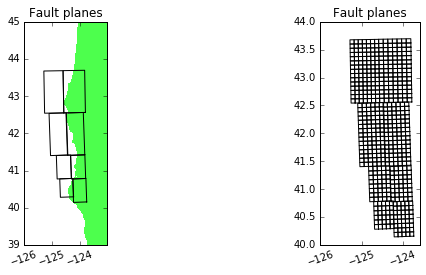

In [8]:
#==========================================
# Select only southern subfaults:

# read topo file for CA:
topo = topotools.Topography()
topo.read('etopo1_-126_-123_39_45_1min.tt3',3)

fault.subfaults = fault.subfaults[:8]

if 1:
    figure(figsize=(10,4))
    ax = subplot(121);
    fault.plot_subfaults(ax)
    xticks(range(-126,-123));
    contourf(topo.X,topo.Y,topo.Z,[0,20000],colors=[[.3,1,.3]])

# Now subdivide each subfault further

new_subfaults = []  # to accumulate all new subfaults

phi_plate = 60.  # angle oceanic plate moves clockwise from north, to set rake

for subfault in fault.subfaults:
    subfault.rake = subfault.strike - phi_plate - 180.
    # subdivide into nstrike x ndip subfaults, based on the dimensions of the
    # fault:
    nstrike = int(subfault.length/8000)
    ndip = int(subfault.width/8000)
    f = dtopotools.SubdividedPlaneFault(subfault, nstrike, ndip)
    new_subfaults = new_subfaults + f.subfaults

# reset fault.subfaults to the new list of all subfaults after subdividing:
new_fault = dtopotools.Fault(subfaults = new_subfaults)
n = len(new_fault.subfaults)
print "Subdivided fault has %s subfaults" % n

if 1:
    ax = subplot(122);
    new_fault.plot_subfaults(ax)
    xticks(range(-126,-123));

### Compute subfault distances, covariance matrix for Gaussian, eigenmodes:

In [19]:
D, Dstrike, Ddip = compute_subfault_distances(new_fault)

# make correlation matrix:
# Gaussian with correlation lengths Lstrike and Ldip:
Lstrike = 130e3
Ldip = 40e3

print "Correlation lengths: Lstrike = %g, Ldip = %g" % (Lstrike,Ldip)
r = sqrt((Dstrike/Lstrike)**2 + (Ddip/Ldip)**2)
C = exp(-r)


lengths = array([s.length for s in fault.subfaults])
widths = array([s.width for s in fault.subfaults])
areas = lengths * widths
total_area = sum(areas)

Mw_desired = 8.8
Mo_desired = 10.**(1.5*Mw_desired + 9.05)
mean_slip = Mo_desired / (fault.subfaults[0].mu * total_area)
print "mean_slip %g meters required for Mw %s" % (mean_slip, Mw_desired)

# Turn this into a constant vector:
mean_slip = mean_slip * ones(n)

alpha = 0.5
sigma_slip = alpha * mean_slip


## Lognormal:
Cov_g = log((sigma_slip/mean_slip) * (C*(sigma_slip/mean_slip)).T + 1.)
mean_slip_g = log(mean_slip) - diag(Cov_g)/2.

## This should be the same:
Cov_g = log(alpha**2 * C + 1.)

# Find eigenvalues, and eigenvector matrix.
# Columns V[:,k] are eigenvectors.

print "Finding eigenmodes from %s by %s matrix C" % (n,n)
lam, V = eig(Cov_g)
    
eigenvals = real(lam)  # imaginary parts should be at rounding level
V = real(V)

# Sort eigenvalues:
i = list(argsort(lam))
i.reverse()
lam = lam[i]
V = V[:,i]

Correlation lengths: Lstrike = 130000, Ldip = 40000
mean_slip 11.1657 meters required for Mw 8.8
Finding eigenmodes from 540 by 540 matrix C


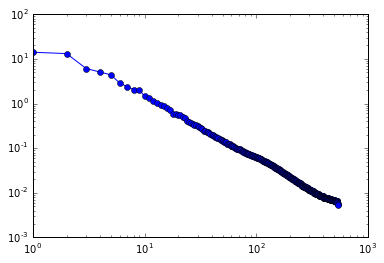

In [20]:
lam40 = lam.copy()
loglog(range(1,len(lam40)), lam40[1:],'b-o')

### Choose a taper

Here we taper only toward the down-dip edge

In [10]:
# Taper:
max_depth = 20000.
tau = lambda d: 1. - exp((d - max_depth)*20/max_depth)

### Function KL to compute the slip patterns

`z` is the input vector, assumed to be Gaussian N(0,1) random numbers.

The K-L modes `V` and eigenvalues `lam` used here were computed from `Cov_g` above so that when we sum the K-L series and then exponentiate we will have slips with the desired statistics. The exponentiation is done in this routine:

In [11]:
def KL(z):
    KL_slip = 0.*mean_slip_g.copy()  # drop the mean slip and rescale later
    # add in the terms in the K-L expansion:  (dropping V[:,0])
    for k in range(1,len(z)):
        KL_slip += z[k] * sqrt(lam[k]) * V[:,k]
    
    ## Exponentiate to get Lognormal distribution:
    KL_slip = exp(KL_slip)
    
    # Set the fault slip for the resulting realization:
    for j,s in enumerate(new_fault.subfaults):
        s.slip = KL_slip[j] * tau(s.depth)
        
    # Rescale to have desired magnitude:
    Mo = new_fault.Mo()
    KL_slip *= Mo_desired/Mo
    for j,s in enumerate(new_fault.subfaults):
        s.slip = KL_slip[j] * tau(s.depth)
    
    return KL_slip

### Apply Okada to unit sources:

Since we are using the Lognormal distribution we cannot apply Okada to each eigenmode directly.  Instead we apply Okada to each unit source and then take linear combinations of these for any particular slip distribution. A unit source has slip 1 on one subfault and slip 0 on all others.  We must compute the seafloor deformation for each such unit source, one for each subfault in the model (540 in the example used here.)

In [12]:
# grid on which to compute deformation:
nx_dtopo = 181
ny_dtopo = 361
x_dtopo = linspace(-126,-123,nx_dtopo)
y_dtopo = linspace(39,45,ny_dtopo)

n_subfaults = len(new_fault.subfaults)
dZ = zeros((ny_dtopo, nx_dtopo, n_subfaults)) # to store sea floor deformation corresponding to each mode V[:,j]

for j in range(n_subfaults):
    sfault = dtopotools.Fault(subfaults = [new_fault.subfaults[j]])
    sfault.subfaults[0].slip = 1.
    dtopo = sfault.create_dtopography(x_dtopo,y_dtopo,times=[1.], verbose=False)
    sys.stdout.write('%i...' % j)
    sys.stdout.flush()
    dZ[:,:,j] = dtopo.dZ[0,:,:]

0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...119...120...121...122...123...124...125...126...127...128...129...130...131...132...133...134...135...136...137...138...139...140...141...142...143...144...145...146...147...148...149...150...151...152...153...154...155...156...157...158...159...160...161...162...163...164...165...166...167...168...169...170...171...172...173...174...175...176...177...178...179...180...181...182...183...184...

### Auxiliary functions to evaluate for each realization

Compute the potential energy in the offshore deformation, and the subsidence/uplift at Crescent City.

In [16]:
def PotentialEnergy(dZr):
    dy = 1./60. * 111.e3  # m
    dx = dy * cos(topo.Y * pi/180.)  # m
    grav = 9.81  # m/s^2
    rho_water = 1000  # kg/m^3
    eta = ma.masked_where(topo.Z>0, dZr)
    Energy = sum(eta**2 * dx * dy) * grav * rho_water * 1e-15  # PetaJoules
    return Energy

i1cc = find(dtopo.x<xcc).max()
j1cc = find(dtopo.y<ycc).max()
a1cc = (xcc-dtopo.x[i1cc])/(dtopo.x[i1cc+1]-dtopo.x[i1cc])
a2cc = (ycc-dtopo.y[j1cc])/(dtopo.y[j1cc+1]-dtopo.y[j1cc])
if (a1cc<0.) or (a1cc>1.) or (a2cc<0.) or (a2cc>1.):
    print '*** Interpolation to CC not correct!'

def dZ_CrescentCity(dZr):
    dzy1 = (1.-a1cc)*dZr[j1cc,i1cc] + a1cc*dZr[j1cc,i1cc+1]
    dzy2 = (1.-a1cc)*dZr[j1cc+1,i1cc] + a1cc*dZr[j1cc+1,i1cc+1]
    dzcc = (1.-a2cc)*dzy2 + a2cc*dzy1
    return dzcc

## Compute statistics from 20,000 realizations:


In [20]:
random.seed(12345)
ntrials = 20000
nterms_max = 60  # max number of terms to use
zvals = randn(ntrials,nterms_max+1)   # generate ntrials sets of random numbers
save('data/zvals.npy',zvals)  # archive the set of z values generated

In [21]:
def test2(zvals, nterms=7):
    ntrials = zvals.shape[0]
    nterms1 = zvals.shape[1] - 1
    
    Energy = zeros(ntrials)
    Amplitude = zeros(ntrials)
    z_shore = zeros(ntrials)
    EtaMax = zeros(ntrials)
    
    #zvals = zeros((ntrials,nterms+1))
    for j in range(ntrials):
        z = zvals[j,:nterms+1]   #randn(nterms+1)  # choose random z for this realization
        KL_slip = KL(z)
        dZr = dot(dZ,KL_slip)  # linear combination of dZ from unit sources
        Energy[j] = PotentialEnergy(dZr)
        z_offshore = where(topo.Z < 0, dZr, 0.)
        Amplitude[j] = z_offshore.max() - z_offshore.min()
        z_shore[j] = dZ_CrescentCity(dZr)
        EtaMax[j] = z_offshore.max()
    return Energy, Amplitude, z_shore, EtaMax, zvals

## Truncate the series at various points

The next cell will take several minutes to execute...

In [22]:
nterms_list = range(1,10) + range(10,65,5)
for nterms in nterms_list:
    print "nterms = %i" % nterms
    Energy, Amplitude, z_shore, EtaMax, zvals = test2(zvals, nterms)

    DepthProxy = EtaMax - z_shore
    realizations = pd.DataFrame()
    realizations['Energy'] = Energy
    realizations['Amplitude'] = Amplitude
    realizations['subsidence / uplift'] = z_shore
    realizations['EtaMax'] = EtaMax
    realizations['depth proxy'] = DepthProxy
    realizations.to_pickle('data/realizations_2d_' + str(nterms) + '.pkl') # save results

nterms = 1
nterms = 2
nterms = 3
nterms = 4
nterms = 5
nterms = 6
nterms = 7
nterms = 8
nterms = 9
nterms = 10
nterms = 15
nterms = 20
nterms = 25
nterms = 30
nterms = 35
nterms = 40
nterms = 45
nterms = 50
nterms = 55
nterms = 60


## Compare KDE plots

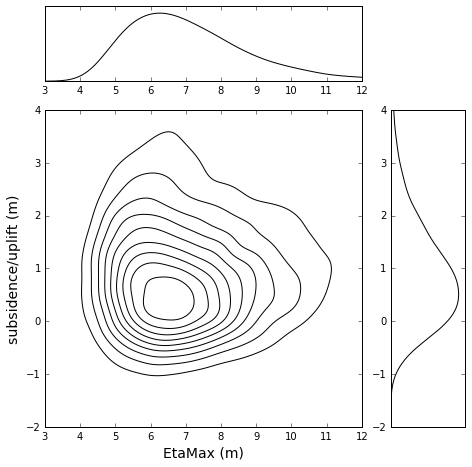

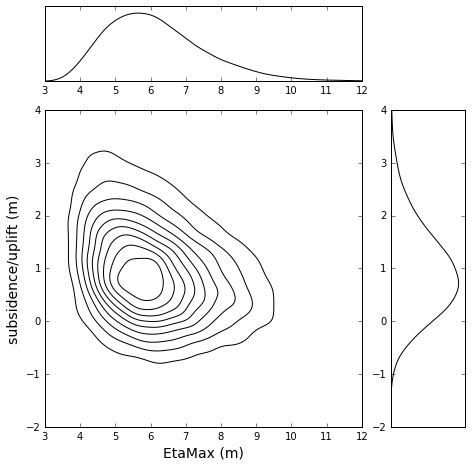

In [30]:
Q1 = 'EtaMax'
Q2 = 'subsidence / uplift'

Nx = 200
Ny = 201

x0 = 3.
x1 = 12.

y0 = -2.
y1 = 4.

x = np.linspace(x0,x1,Nx)
y = np.linspace(y0,y1,Ny)

X,Y = np.meshgrid(x,y)

xy = np.vstack((X.flatten(),Y.flatten()))


nterms = 60
realizations = pd.read_pickle('data/realizations_2d_%s.pkl' % nterms)
rvals = vstack((realizations[Q1].T, realizations[Q2].T))
kde = stats.gaussian_kde(rvals)
p = kde.pdf(xy) * (x1-x0)*(y1-y0)/float(Nx*Ny)
rho = reshape(p,(Ny,Nx))

KDEplots.joint_plot(X,Y,P,xname='EtaMax (m)',yname='subsidence/uplift (m)')
savefig('joint_Eta_DBshore_60b.jpg',bbox_inches='tight')


nterms = 7
realizations2 = pd.read_pickle('data/realizations_2d_%s.pkl' % nterms)
rvals = vstack((realizations2[Q1].T, realizations2[Q2].T))
kde2 = stats.gaussian_kde(rvals)
p2 = kde2.pdf(xy) * (x1-x0)*(y1-y0)/float(Nx*Ny)
rho2 = reshape(p2,(Ny,Nx))

KDEplots.joint_plot(X,Y,rho2,xname='EtaMax (m)',yname='subsidence/uplift (m)')
savefig('joint_Eta_DBshore_7b.jpg',bbox_inches='tight')


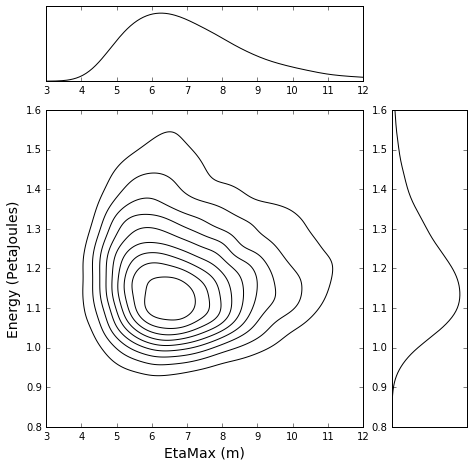

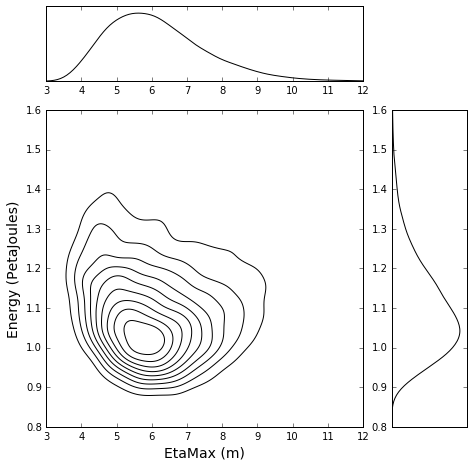

In [29]:
Q1 = 'EtaMax'
Q2 = 'Energy'

Nx = 200
Ny = 201

x0 = 3.
x1 = 12.

y0 = 0.8
y1 = 1.6

x = np.linspace(x0,x1,Nx)
y = np.linspace(y0,y1,Ny)

X,Y = np.meshgrid(x,y)

xy = np.vstack((X.flatten(),Y.flatten()))


nterms = 60
realizations = pd.read_pickle('data/realizations_2d_%s.pkl' % nterms)
rvals = vstack((realizations[Q1].T, realizations[Q2].T))
kde = stats.gaussian_kde(rvals)
p = kde.pdf(xy) * (x1-x0)*(y1-y0)/float(Nx*Ny)
rho = reshape(p,(Ny,Nx))

KDEplots.joint_plot(X,Y,rho,xname='EtaMax (m)',yname='Energy (PetaJoules)')
savefig('joint_Eta_Energy_60b.jpg',bbox_inches='tight')

nterms = 7
realizations2 = pd.read_pickle('data/realizations_2d_%s.pkl' % nterms)
rvals = vstack((realizations2[Q1].T, realizations2[Q2].T))
kde2 = stats.gaussian_kde(rvals)
p2 = kde2.pdf(xy) * (x1-x0)*(y1-y0)/float(Nx*Ny)
rho2 = reshape(p2,(Ny,Nx))

KDEplots.joint_plot(X,Y,rho2,xname='EtaMax (m)',yname='Energy (PetaJoules)')
savefig('joint_Eta_Energy_7b.jpg',bbox_inches='tight')

## Total variation distance between densities:

In [34]:
#nterms_list = range(1,10) + range(10,60,5)

tv_list = []
for nterms in nterms_list:
    realizations2 = pd.read_pickle('data/realizations_2d_%s.pkl' % nterms)
    rvals = vstack((realizations2[Q1].T, realizations2[Q2].T))
    kde2 = stats.gaussian_kde(rvals)
    p2 = kde2.pdf(xy) * (x1-x0)*(y1-y0)/float(Nx*Ny)
    rho2 = reshape(p2,(Ny,Nx))
    tvdist = sum(abs(rho-rho2))
    print "nterms = %i,  TVdist = %g" % (nterms,tvdist)
    tv_list.append(tvdist)

nterms = 1,  TVdist = 1.84252
nterms = 2,  TVdist = 1.37863
nterms = 3,  TVdist = 1.18172
nterms = 4,  TVdist = 1.13474
nterms = 5,  TVdist = 0.691511
nterms = 6,  TVdist = 0.607116
nterms = 7,  TVdist = 0.48084
nterms = 8,  TVdist = 0.437449
nterms = 9,  TVdist = 0.423956
nterms = 10,  TVdist = 0.381046
nterms = 15,  TVdist = 0.290917
nterms = 20,  TVdist = 0.214014
nterms = 25,  TVdist = 0.156395
nterms = 30,  TVdist = 0.131629
nterms = 35,  TVdist = 0.0936988
nterms = 40,  TVdist = 0.0693274
nterms = 45,  TVdist = 0.0453337
nterms = 50,  TVdist = 0.0307449
nterms = 55,  TVdist = 0.0174375
nterms = 60,  TVdist = 0


In [39]:
tv40 = vstack((nterms_list,tv_list)).T
tv40.shape
savetxt('tv40.txt',tv40)

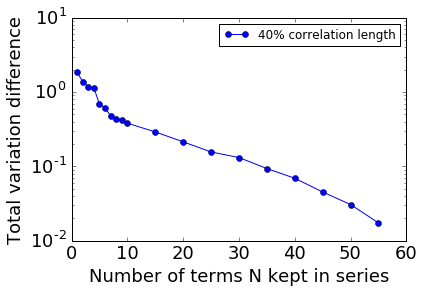

In [35]:
semilogy(nterms_list,tv_list,'o-',label='40% correlation length')
xlabel('Number of terms N kept in series', fontsize=18)
ylabel('Total variation difference', fontsize=18)
xticks(fontsize=18)
yticks(fontsize=18)
legend(loc='upper right')
savefig('tvdist.jpg',dpi=250,bbox_inches='tight')

# Redo with shorter correlation length

We now repeat several of the previous experiments with shorter correlation lengths `Lstrike` and `Ldip` that are only about 20% of the fault length and width.

In [22]:
D, Dstrike, Ddip = compute_subfault_distances(new_fault)

# make correlation matrix:
# Gaussian with correlation lengths Lstrike and Ldip:
Lstrike = 65e3
Ldip = 20e3

print "Correlation lengths: Lstrike = %g, Ldip = %g" % (Lstrike,Ldip)
r = sqrt((Dstrike/Lstrike)**2 + (Ddip/Ldip)**2)
C = exp(-r)


lengths = array([s.length for s in fault.subfaults])
widths = array([s.width for s in fault.subfaults])
areas = lengths * widths
total_area = sum(areas)

Mw_desired = 8.8
Mo_desired = 10.**(1.5*Mw_desired + 9.05)
mean_slip = Mo_desired / (fault.subfaults[0].mu * total_area)
print "mean_slip %g meters required for Mw %s" % (mean_slip, Mw_desired)

# Turn this into a constant vector:
mean_slip = mean_slip * ones(n)

alpha = 0.5
sigma_slip = alpha * mean_slip


## Lognormal:
Cov_g = log((sigma_slip/mean_slip) * (C*(sigma_slip/mean_slip)).T + 1.)
mean_slip_g = log(mean_slip) - diag(Cov_g)/2.

## This should be the same:
Cov_g = log(alpha**2 * C + 1.)

# Find eigenvalues, and eigenvector matrix.
# Columns V[:,k] are eigenvectors.

print "Finding eigenmodes from %s by %s matrix C" % (n,n)
lam, V = eig(Cov_g)
    
eigenvals = real(lam)  # imaginary parts should be at rounding level
V = real(V)

# Sort eigenvalues:
i = list(argsort(lam))
i.reverse()
lam = lam[i]
V = V[:,i]

Correlation lengths: Lstrike = 65000, Ldip = 20000
mean_slip 11.1657 meters required for Mw 8.8
Finding eigenmodes from 540 by 540 matrix C


Plot the eigenvalues.  They appear to decay like $1/k^{3/2}$.  But note that these are in 2d indexed with a single index, and that these are eigenvalues of $C^g$, the covariance matrix used for the Gaussian before exponentiating to get the lognormal.

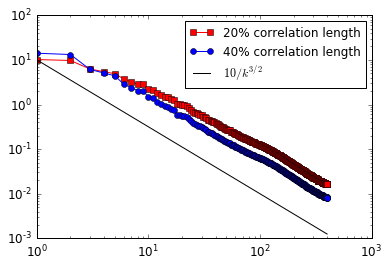

In [34]:
lam20 = lam.copy()
nlam = 400
loglog(range(1,nlam), lam20[1:nlam],'r-s', label='20% correlation length')
loglog(range(1,nlam), lam40[1:nlam],'b-o', label='40% correlation length')
k2 = 10./arange(1,nlam)**1.5
loglog(range(1,nlam), k2, 'k', label='$10/k^{3/2}$')
legend(loc='upper right')
xticks(fontsize=12);
yticks(fontsize=12);


In [ ]:
# Plot first several eigenmodes:

figure(figsize=(12,8))

cmap_slip = colormaps.make_colormap({0:'g',0.5:'w',1.:'m'})

ni = 2; nj = 4;
ax = axes((.1,.3,.2,.4))
contourf(topo.X,topo.Y,topo.Z,[0,20000],colors=[[.3,1,.3]])
contour(topo.X,topo.Y,topo.Z,[0],colors='g')
plot([xcc],[ycc],'wo')
plot([xcc],[ycc],'kx')
fault.plot_subfaults(ax)
axis((-126,-123,40,44))

for ii in range(ni):
    for jj in range(nj):
        pij = ii*nj + jj
        if ii==0:
            ax = axes((.35 + jj*0.14,.5,.12,.38))
        else:
            ax = axes((.35 + jj*0.14,.1,.12,.38))
            
        V_amp = sqrt(sum(V[:,pij]**2))    # abs(V[:,pij]).max()
        #weight = sqrt(eigenvals[pij]) * V_amp / mean_amp
        for j,s in enumerate(new_fault.subfaults):
            s.slip = V[j,pij] * 15.

        new_fault.plot_subfaults(ax,slip_color=True,cmin_slip=-1,cmax_slip=1,
                plot_box=0., cmap_slip=cmap_slip, colorbar_shrink=0)
        title('Mode %s' % pij)
        axis('off')

#savefigp('CSZmodes.jpg')

In [ ]:
def KL(z):
    KL_slip = 0.*mean_slip_g.copy()  # drop the mean slip and rescale later
    # add in the terms in the K-L expansion:  (dropping V[:,0])
    for k in range(1,len(z)):
        KL_slip += z[k] * sqrt(lam[k]) * V[:,k]
    
    ## Exponentiate to get Lognormal distribution:
    KL_slip = exp(KL_slip)
    
    # Set the fault slip for the resulting realization:
    for j,s in enumerate(new_fault.subfaults):
        s.slip = KL_slip[j] * tau(s.depth)
        
    # Rescale to have desired magnitude:
    Mo = new_fault.Mo()
    KL_slip *= Mo_desired/Mo
    for j,s in enumerate(new_fault.subfaults):
        s.slip = KL_slip[j] * tau(s.depth)
    
    return KL_slip

In [ ]:
### Densities computed from large number of realizations:

def test(ntrials = 10000, nterms=60):
    Energy = zeros(ntrials)
    Amplitude = zeros(ntrials)
    z_shore = zeros(ntrials)
    EtaMax = zeros(ntrials)
    
    zvals = zeros((ntrials,nterms+1))
    for j in range(ntrials):
        z = randn(nterms+1)  # choose random z for this realization
        zvals[j,:] = z
        KL_slip = KL(z)
        dZr = dot(dZ,KL_slip)  # linear combination of dZ from unit sources
        Energy[j] = PotentialEnergy(dZr)
        z_offshore = where(topo.Z < 0, dZr, 0.)
        Amplitude[j] = z_offshore.max() - z_offshore.min()
        z_shore[j] = dZ_CrescentCity(dZr)
        EtaMax[j] = z_offshore.max()
    return Energy, Amplitude, z_shore, EtaMax, zvals

random.seed(12345)
ntrials = 20000
print "Generating %s samples..." % ntrials
Energy, Amplitude, z_shore, EtaMax, zvals = test(ntrials = ntrials, nterms=60)

DepthProxy = EtaMax - z_shore
realizations = pd.DataFrame()
realizations['Energy'] = Energy
realizations['Amplitude'] = Amplitude
realizations['subsidence / uplift'] = z_shore
realizations['EtaMax'] = EtaMax
realizations['depth proxy'] = DepthProxy

realizations.to_pickle('data20/realizations_2d_' + str(nterms) + '.pkl')
save('data20/zvals.txt',zvals)

kde = stats.gaussian_kde(realizations.values[:,2:4].T)
p = kde.pdf(xy) * (x1-x0)*(y1-y0)/float(N**2)
P = reshape(p,(N,N))

In [ ]:
def test2(zvals, nterms=7):
    ntrials = zvals.shape[0]
    nterms1 = zvals.shape[1] - 1
    
    Energy = zeros(ntrials)
    Amplitude = zeros(ntrials)
    z_shore = zeros(ntrials)
    EtaMax = zeros(ntrials)
    
    #zvals = zeros((ntrials,nterms+1))
    for j in range(ntrials):
        z = zvals[j,:nterms+1]   #randn(nterms+1)  # choose random z for this realization
        #zvals[j,:] = z
        KL_slip = KL(z)
        dZr = dot(dZ,KL_slip)  # linear combination of dZ from unit sources
        Energy[j] = PotentialEnergy(dZr)
        z_offshore = where(topo.Z < 0, dZr, 0.)
        Amplitude[j] = z_offshore.max() - z_offshore.min()
        z_shore[j] = dZ_CrescentCity(dZr)
        EtaMax[j] = z_offshore.max()
    return Energy, Amplitude, z_shore, EtaMax, zvals

In [ ]:
nterms_list = range(1,10) + range(10,60,5)
for nterms in nterms_list:
    print "nterms = %i" % nterms
    Energy, Amplitude, z_shore, EtaMax, zvals = test2(zvals, nterms)

    DepthProxy = EtaMax - z_shore
    realizations2 = pd.DataFrame()
    realizations2['Energy'] = Energy
    realizations2['Amplitude'] = Amplitude
    realizations2['subsidence / uplift'] = z_shore
    realizations2['EtaMax'] = EtaMax
    realizations2['depth proxy'] = DepthProxy
    realizations2.to_pickle('data20/realizations_2d_' + str(nterms) + '.pkl')

In [ ]:
tv_list_20 = []
for nterms in nterms_list:
    realizations2 = pd.read_pickle('data20/realizations_2d_%s.pkl' % nterms)
    kde2 = stats.gaussian_kde(realizations2.values[:,2:4].T)
    p2 = kde2.pdf(xy) * (x1-x0)*(y1-y0)/float(N**2)
    P2 = reshape(p2,(N,N))
    tvdist = sum(abs(P-P2))
    print "nterms = %i,  TVdist = %g" % (nterms,tvdist)
    tv_list_20.append(tvdist)

In [ ]:
semilogy(nterms_list,tv_list_20,'r-s',label='20% correlation length')
semilogy(nterms_list,tv_list,'b-o',label='40% correlation length')
#semilogy(array(nterms_list)+8,tv_list,'g-o',label='40% displaced')

xlabel('Number of terms N kept in series', fontsize=18)
ylabel('Total variation distance', fontsize=18)
xticks(fontsize=18)
yticks(fontsize=18)
legend(loc='upper right')
savefigp('tvdist.jpg')